In [1]:
from PIL import Image
import numpy as np
import itertools
from matplotlib import pyplot as plt

## Step 1 - Design and build a dataset $X$ for character recognition of 20 16x16-pixel images (256 pixels per image) from online exemplars.

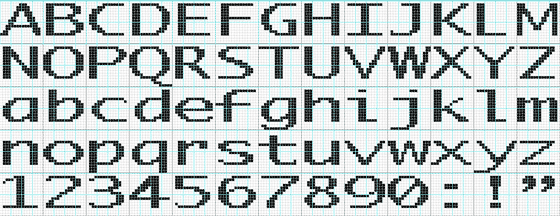

In [2]:
im = Image.open('alphabet.gif')
im

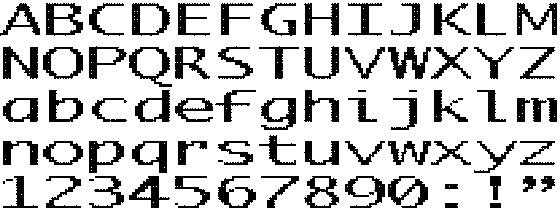

In [3]:
# convert image to black and white
im = im.convert('1')
im

In [4]:
np.array(im)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [5]:
w, h = im.size
print('width: ', w)
print('height:', h)

width:  560
height: 216


In [6]:
image_height = 16
image_width = 16
m = 13
n = 5
image_size = image_height*image_width
im_resize = im.resize((m*image_width, n*image_height))

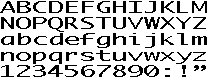

In [7]:
im_resize

In [8]:
pix = np.array(im_resize)
nrow, ncol = pix.shape
print(pix.shape)
print(pix.dtype)
# chanage the data type from bool to double
pix = pix.astype(np.float32)
print(pix.dtype)

(80, 208)
bool
float32


In [9]:
# construct the traing dataset 
n_sample = 20
n_channel  = 1
dataset = np.ndarray(shape=(n_sample, n_channel, image_height, image_width), dtype=np.float32)
dataset.shape
dataset.dtype

dtype('float32')

In [10]:
idx = 0
for i in range(5):
    for j in range(13):
        if( (i == 0 or i == 4) and ( 0 <= j <= 9) ):
            x = pix[(i*image_height):( (i+1)*image_height), (j*image_width):( (j+1)*image_width)]
            dataset[idx] = x
            idx += 1
print("All images to array!")

All images to array!


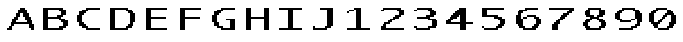

In [11]:
fig, axs = plt.subplots(1, 20 ,figsize=(12,12))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset):
        ax.imshow(dataset[i, 0], cmap='gray', interpolation='nearest', vmin=0, vmax=1)
        ax.axis('off')
    else:
        ax.remove()
plt.show()

In [12]:
dataset_reshaped = dataset.reshape((n_sample, 1, -1))

In [13]:
dataset_reshaped.shape

(20, 1, 256)

In [14]:
print(dataset_reshaped)
dataset_labels =np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] ) 
print(dataset_labels)

[[[1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]]

 ...

 [[1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]]]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [15]:
#lables of images
labels = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
         '1', '2', '3', '4', '5', '6', '7', '8', '9', '0'] )
len(labels)
labels

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '0'], dtype='<U1')

In [16]:
import random 
random.seed(1)
lst = list(range(n_sample))
index = random.sample(lst, n_sample//2)
print(index) 
# index = [0, 1, 4, 5, 7, 12, 13, 14, 17, 19]
dataset_train  = dataset[index]
# dataset_train.shape
# mask = np.ones(n_sample, dtype=bool)
# mask[index] = False
# dataset_test  = dataset[mask]
# dataset_test.shape
labels_train  = labels[index]
print(labels_train)

[4, 18, 2, 8, 3, 7, 12, 14, 13, 10]
['E' '9' 'C' 'I' 'D' 'H' '3' '5' '4' '1']


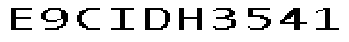

In [17]:
# training dataset
fig, axs = plt.subplots(1, n_sample//2 ,figsize=(6,6))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset_train):
        ax.imshow(dataset_train[i, 0], cmap='gray', interpolation='nearest')
        ax.axis('off')
        #save images to jepg image files
        temp = Image.fromarray(dataset_train[i, 0].astype('uint8')*255, "L")
        temp.save("training_" + str(i) + ".jpeg")
    else:
        ax.remove()
plt.show()

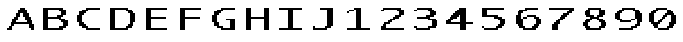

In [18]:
#test dataset (including images in the training set!)
fig, axs = plt.subplots(1, n_sample ,figsize=(12,12))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset):
        ax.imshow(dataset[i, 0], cmap='gray', interpolation='nearest')
        ax.axis('off')
        temp = Image.fromarray(dataset[i, 0].astype('uint8')*255, "L")
        temp.save("test_" + str(i) + ".jpeg")
    else:
        ax.remove()
plt.show()

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [40]:
class TrainableVectorLayer(nn.Module):
  def __init__(self,D_in,D_out):
    super(TrainableVectorLayer, self).__init__()
    self.linear = nn.Linear(D_in,D_out)
    self.acti = nn.Sigmoid()
  def forward(self, x):
    outs = self.linear(x)
    res = self.acti(outs)
    return res

In [41]:
model = TrainableVectorLayer(256,20)

## Step 3 - Train your SLP on a representative subset (10 images that your group selects and documents) from the 20-image datasetdeveloped in 1), above.  

In [42]:
# read images from jpeg files in the training set
data_train = np.ndarray(shape=(n_sample//2, n_channel, image_height, image_width), dtype=np.float32)
y_train_label = [x+1 for x in index]
for i in range(n_sample//2):
    filename = "training_" + str(i) + ".jpeg"
    print(filename)
    temp = Image.open(filename)
    # convert image to black and white
    temp = temp.convert('1')
    data_train[i, 0] = np.array(temp)   
print(y_train_label)

training_0.jpeg
training_1.jpeg
training_2.jpeg
training_3.jpeg
training_4.jpeg
training_5.jpeg
training_6.jpeg
training_7.jpeg
training_8.jpeg
training_9.jpeg
[5, 19, 3, 9, 4, 8, 13, 15, 14, 11]


In [43]:
dataset_train_reshaped = data_train.reshape((n_sample//2, 1, -1))

In [51]:
# Use the nn package to define our model
# Fully-connected Network 
# define loss function.
loss_fn = nn.BCELoss()
# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use RMSprop; the optim package contains many other
# optimization algorithms. The first argument to the RMSprop constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-3
# optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for t in range (600):
    for i, data in enumerate(dataset_train_reshaped):
        x = torch.from_numpy(data).float()
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)[0]
        y = [0] * 20
        y[y_train_label[i]-1] = 1
        y = torch.tensor(y).float()
        loss = loss_fn(y_pred,y)
        if (i % 10 == 0 ) and (t % 10 == 0 ):
            print("Epoch {} - loss: {}".format(t, loss.item()))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

Epoch 0 - loss: 0.6498968601226807
Epoch 10 - loss: 0.10633615404367447
Epoch 20 - loss: 0.06652740389108658
Epoch 30 - loss: 0.04384090378880501
Epoch 40 - loss: 0.031062880530953407
Epoch 50 - loss: 0.023268133401870728
Epoch 60 - loss: 0.018148822709918022
Epoch 70 - loss: 0.014589528553187847
Epoch 80 - loss: 0.012004324235022068
Epoch 90 - loss: 0.010061058215796947
Epoch 100 - loss: 0.008559477515518665
Epoch 110 - loss: 0.007372564170509577
Epoch 120 - loss: 0.0064164577051997185
Epoch 130 - loss: 0.005633791908621788
Epoch 140 - loss: 0.004984195344150066
Epoch 150 - loss: 0.0044385893270373344
Epoch 160 - loss: 0.003975468222051859
Epoch 170 - loss: 0.003578751813620329
Epoch 180 - loss: 0.003236111719161272
Epoch 190 - loss: 0.002938000950962305
Epoch 200 - loss: 0.0026769295800477266
Epoch 210 - loss: 0.0024469387717545033
Epoch 220 - loss: 0.0022432284895330667
Epoch 230 - loss: 0.002061929553747177
Epoch 240 - loss: 0.0018998496234416962
Epoch 250 - loss: 0.001754359109327

## Step 4 - Test your SLP on the entire 20-image dataset developed in 1), above -- with no noise introduced into the input dataset

In [ ]:
#Compute metrics (described below) called fraction-of-hits (Fh) and fraction-of-false-alarms (Ffa)
# 0 -- black
# 1 -- white
def metrics(target, pred):
    Fh = (sum( (i == j) and (i == 0)  for i, j in zip(target, pred)) )/ sum(target == 0)
    Ffa = (sum( (i != j) and (i == 1)  for i, j in zip(target, pred)) )/ sum(target == 1)
    return Fh, Ffa

In [58]:
cor = 0
for i, data in enumerate(dataset_reshaped):
    x = torch.from_numpy(data)
    label = dataset_labels[i]
    out = torch.argmax(model(x)) + 1
    if out == label:
        cor += 1 
    print("answer: {},output {}".format(label, out))
print("accuracy:{}".format(cor/20))
## training set[2, 3, 19, 12, 6, 17, 13, 11, 5, 15]

answer: 1,output 14
answer: 2,output 4
answer: 3,output 3
answer: 4,output 4
answer: 5,output 5
answer: 6,output 5
answer: 7,output 3
answer: 8,output 8
answer: 9,output 9
answer: 10,output 13
answer: 11,output 11
answer: 12,output 13
answer: 13,output 13
answer: 14,output 14
answer: 15,output 15
answer: 16,output 3
answer: 17,output 9
answer: 18,output 13
answer: 19,output 19
answer: 20,output 19
accuracy:0.5
